## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal\calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        print(fname)
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#        cv2.imshow('img',img)
        cv2.imwrite("output_images\calibration_corners.jpg", img)
#        cv2.waitKey(500)

cv2.destroyAllWindows()

objpointsArr = np.array(objpoints)
print(objpointsArr.shape)

camera_cal\calibration10.jpg
camera_cal\calibration11.jpg
camera_cal\calibration12.jpg
camera_cal\calibration13.jpg
camera_cal\calibration14.jpg
camera_cal\calibration15.jpg
camera_cal\calibration16.jpg
camera_cal\calibration17.jpg
camera_cal\calibration18.jpg
camera_cal\calibration19.jpg
camera_cal\calibration2.jpg
camera_cal\calibration20.jpg
camera_cal\calibration3.jpg
camera_cal\calibration6.jpg
camera_cal\calibration7.jpg
camera_cal\calibration8.jpg
camera_cal\calibration9.jpg
(17, 54, 3)


## Function to undistort images

In [2]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist



In [3]:
def detect_edges(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 128
    
    # Threshold color channel
    s_binary = np.zeros_like(scaled_sobel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 128
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.

    color_binary = ((sxbinary + s_binary) / 2).astype(np.uint8)
    
    return color_binary

In [4]:
import math

x_offset_bottom_global = 5
x_offset_top_global = 40
y_offset_bottom_global = 99
y_offset_top_global = 60
    
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=6):
    """
    Assuming equation of line is y = m*x + b, we first find average m and b for two side of lines
    In order to reduce noise, I take line with longest length and ignore any lines which slopes too far away from this line
    In order to compute accurate average, i take weighted average with weights being the line length
    Then we find the intersection of these two lines with region of interest
    """
    side1_m = []
    side1_b = []
    side2_m = []
    side2_b = []
    side1_weight = []
    side2_weight = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            if(x1 == x2):
                continue
            m_local = (y2 - y1) / (x2 - x1)
            b_local = y1 - m_local * x1
            weight = ((y2 - y1) * (y2 - y1)) + ((x2 - x1) * (x2 - x1))
            if(m_local < 0):
                side1_m.append(m_local)
                side1_b.append(b_local)
                side1_weight.append(weight)
            else:
                side2_m.append(m_local)
                side2_b.append(b_local)
                side2_weight.append(weight)
            
    
    best1_index = 0
    weight_max = 0
    for i in range(0, len(side1_m)):
        if (weight_max < side1_weight[i]):
            weight_max = side1_weight[i]
            best1_index = i
            
    best2_index = 0
    weight_max = 0
    for i in range(0, len(side2_m)):
        if (weight_max < side2_weight[i]):
            weight_max = side2_weight[i]
            best2_index = i
            
    max_delta_allowed = math.tan(math.radians(5))
    m1_average = 0
    b1_average = 0
    weight1_total = 0
    for i in range(0, len(side1_m)):
        if(abs(side1_m[i] - side1_m[best1_index]) > max_delta_allowed):
            continue
        m1_average += side1_weight[i] * side1_m[i]
        b1_average += side1_weight[i] * side1_b[i]
        weight1_total += side1_weight[i]

    m2_average = 0
    b2_average = 0
    weight2_total = 0
    for i in range(0, len(side2_m)):
        if(abs(side2_m[i] - side2_m[best2_index]) > max_delta_allowed):
            continue
        m2_average += side2_weight[i] * side2_m[i]
        b2_average += side2_weight[i] * side2_b[i]
        weight2_total += side2_weight[i]

    m1_average /= weight1_total
    m2_average /= weight2_total
    b1_average /= weight1_total
    b2_average /= weight2_total

    width = img.shape[1]
    height = img.shape[0]
    y0_region = height * y_offset_bottom_global / 100
    y1_region = height * y_offset_top_global / 100
    
    x1 = int(round((y0_region - b1_average) / m1_average))
    y1 = int(round(y0_region))
    x2 = int(round((y1_region - b1_average) / m1_average))
    y2 = int(round(y1_region))
    cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
    x1 = int(round((y0_region - b2_average) / m2_average))
    y1 = int(round(y0_region))
    x2 = int(round((y1_region - b2_average) / m2_average))
    y2 = int(round(y1_region))
    
    cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [5]:
def find_lane_lines(image):
    """ Finds lane lines in the image and returns the image with lane lines superimposed on it"""
    
    edges = detect_edges(image)
    
    width = image.shape[1]
    height = image.shape[0]
    x0 = width * x_offset_bottom_global / 100
    y0 = height * y_offset_bottom_global / 100
    x1 = width * x_offset_top_global / 100
    y1 = height * y_offset_top_global / 100
    x2 = width - x1
    y2 = y1
    x3 = width - x0
    y3 = y0
    vertices = np.array([[(x0,y0),(x1,y1), (x2,y2), (x3,y3)]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
 
#    plt.figure()
#    plt.imshow(masked_edges, cmap='gray')

    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10 #minimum number of pixels making up a line
    max_line_gap = 10    # maximum gap in pixels between connectable line segments
    edges_color = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    lines_edges = weighted_img(edges_color, image, 0.8, 0.8, 0) 
    
    return lines_edges

In [48]:
def pipeline(img):
    undistorted = cal_undistort(img, objpoints, imgpoints)
    cv2.imwrite("output_images/undistorted.jpg", img)

    src = np.float32([[270,670], [1028,670], [750,490], [536,490]])
    dst = np.float32([[270,670], [1028,670], [1028,490], [270,490]])
   
    img_size = (undistorted.shape[1], undistorted.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    
    warped = cv2.warpPerspective(undistorted, M, img_size)
#    lane_binary = find_lane_lines(undistorted)
#    cv2.imwrite("../output_images/binary_lanes.jpg", img)
    plt.figure()
    plt.imshow(warped)

test_images\straight_lines1.jpg
test_images\straight_lines2.jpg
test_images\test1.jpg
test_images\test2.jpg
test_images\test3.jpg
test_images\test4.jpg
test_images\test5.jpg
test_images\test6.jpg


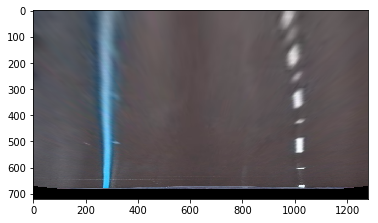

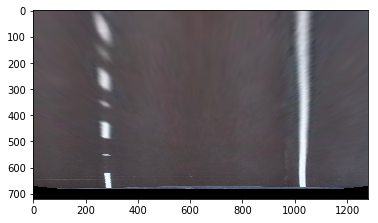

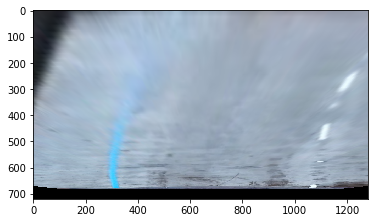

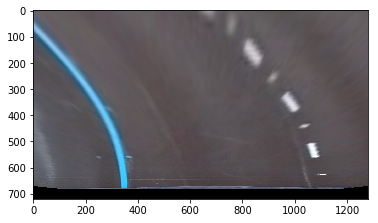

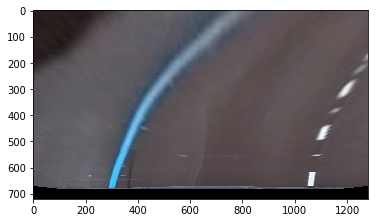

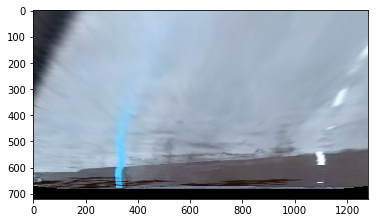

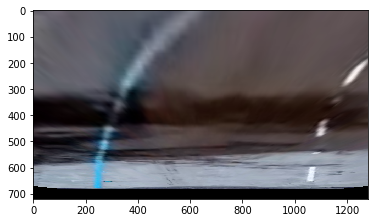

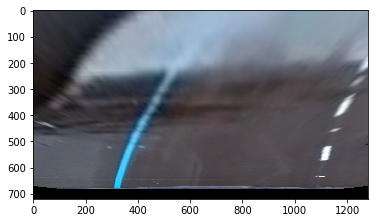

In [49]:
test_images = glob.glob("test_images\*.jpg")
for filename in test_images:
    print (filename)
    img = cv2.imread(filename)
    pipeline(img)
    
    

In [8]:
# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [52]:
isFirstFrame = True

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    mtx = []
    dist = []
    if(isFirstFrame):
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints, gray.shape[::-1], None, None)
        
    undistorted = undist = cv2.undistort(image, mtx, dist, None, mtx)
            
    M = []
    if (isFirstFrame):
        src = np.float32([[270,670], [1028,670], [750,490], [536,490]])
        dst = np.float32([[270,670], [1028,670], [1028,490], [270,490]])
        M = cv2.getPerspectiveTransform(src, dst)
        isFirstFrame = False;
        
    img_size = (undistorted.shape[1], undistorted.shape[0])
    warped = cv2.warpPerspective(undistorted, M, img_size)
    return warped

In [53]:
white_output = 'project_video_result.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

OSError: [WinError 6] The handle is invalid